# Classification Notebook

In [1]:
# Imports
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB


## Import Dataset

In [2]:
# use subset for development 
#TODO: change it
data = pd.read_csv('datasets/training_data.csv')

# use subset for development 
subset_data = data.head(2000)


## Fit and eval model with input data

In [3]:
def train_test_model(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    results = {}
    results['accuracy'] = accuracy_score(Y_test, y_pred)
    results['precision'] = precision_score(Y_test, y_pred, average='weighted')
    results['recall'] = recall_score(Y_test, y_pred, average='weighted')
    results['f1'] = f1_score(Y_test, y_pred, average='weighted')
    results['confusion_matrix'] = confusion_matrix(Y_test, y_pred)
    results['model'] = model
    results['y_pred'] = y_pred
    return results

In [4]:
def display_confusion_matrix(matrix):
    # Display the confusion matrix as an image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(matrix, annot=True, fmt='d')
    # Set the labels
    ax.set_xlabel('Predicted', fontsize=20)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_title('Confusion Matrix', fontsize=20)
    plt.show()
    

## CountVectorizer

In [5]:
def countVectorizerAux(data, ngram_range_max):
    #TODO: change the lowercase
    vectorizer = CountVectorizer(analyzer='word', lowercase=False, stop_words='english', ngram_range=(1, ngram_range_max))
    X = vectorizer.fit_transform(data['text']).toarray()
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    results = {}
    results['X_train'] = X_train
    results['X_test'] = X_test
    results['y_train'] = y_train
    results['y_test'] = y_test
    return results

## TfidfVectorizer

In [6]:
def tfidfVectorizerAux(data, ngram_range_max):
    #TODO: change the lowercase
    vectorizer = TfidfVectorizer(analyzer='word', lowercase=False, stop_words='english', ngram_range=(1, ngram_range_max))
    X = vectorizer.fit_transform(data['text']).toarray()
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    results = {}
    results['X_train'] = X_train
    results['X_test'] = X_test
    results['y_train'] = y_train
    results['y_test'] = y_test
    return results

## Results

### CountVectorized

#### NB 

##### Unigram

0.8375 0.8386939840960593 0.8375 0.8361632320997822


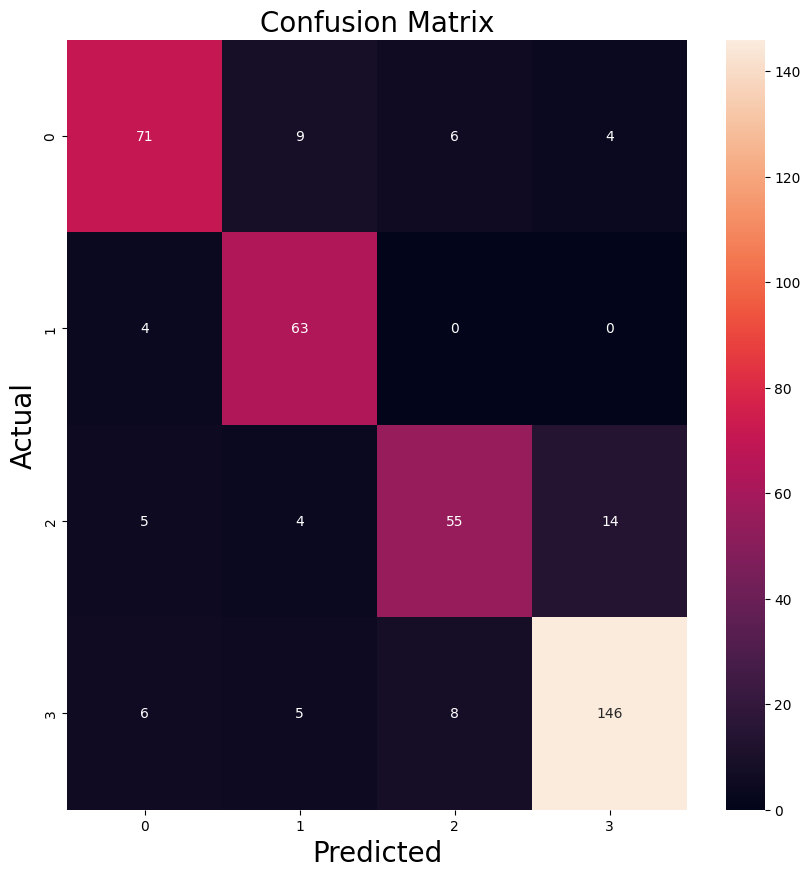

In [7]:
countVectorizerResults = countVectorizerAux(subset_data, 1)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    countVectorizerResults['X_train'], 
    countVectorizerResults['y_train'], 
    countVectorizerResults['X_test'], 
    countVectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Bigram

0.84 0.8539240874279258 0.84 0.8413173396978934


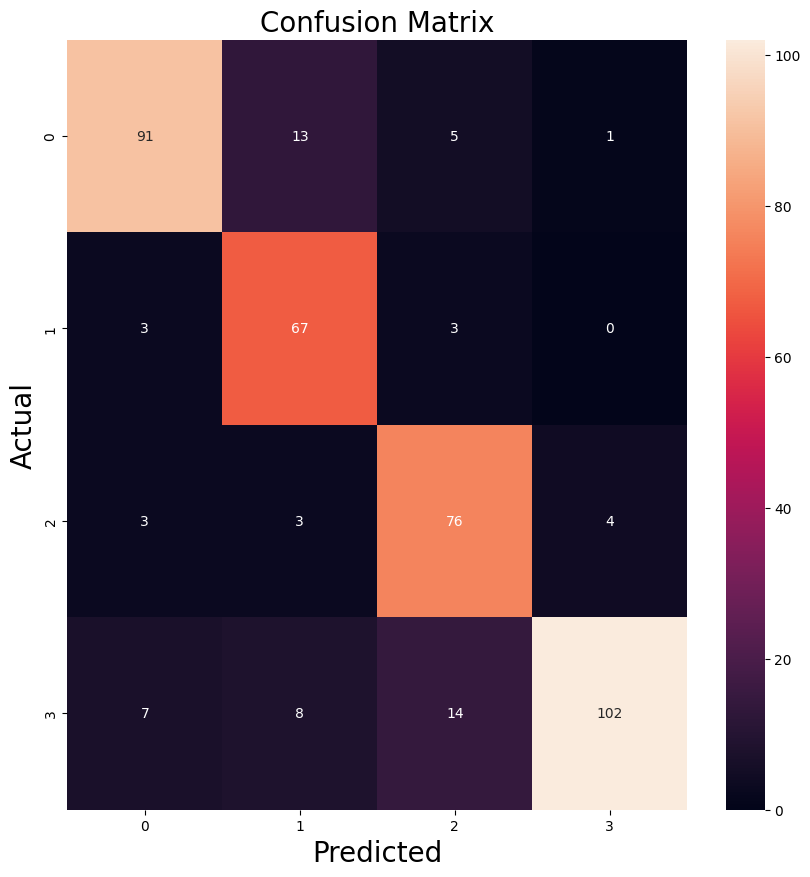

In [8]:
countVectorizerResults = countVectorizerAux(subset_data, 2)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    countVectorizerResults['X_train'], 
    countVectorizerResults['y_train'], 
    countVectorizerResults['X_test'], 
    countVectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Trigram

0.8175 0.8302225691034596 0.8175 0.8188750199664264


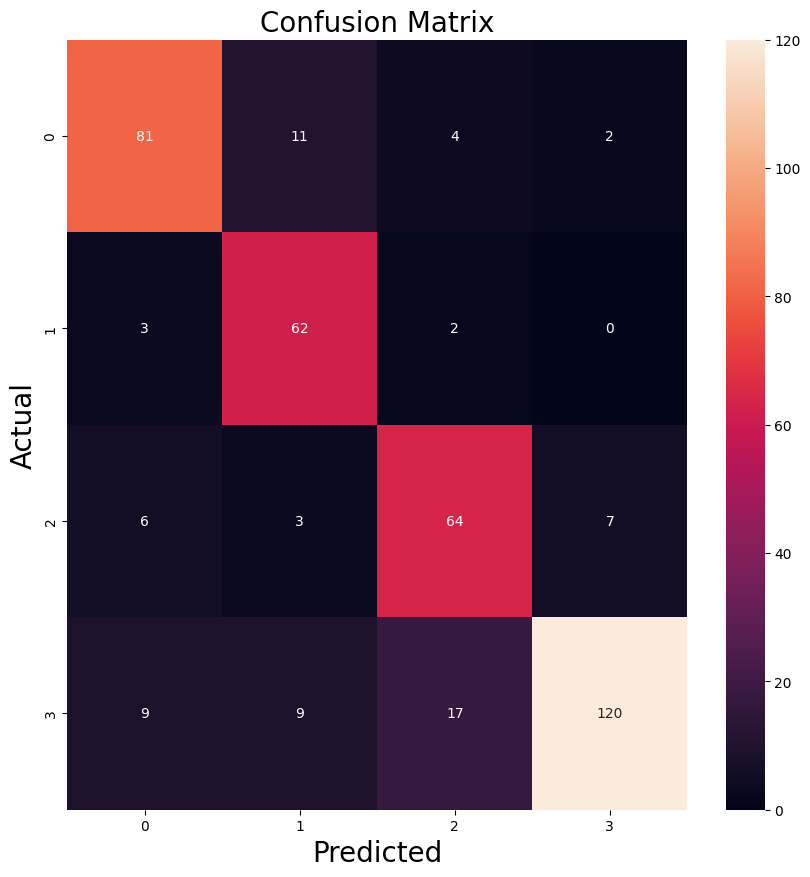

In [9]:
countVectorizerResults = countVectorizerAux(subset_data, 3)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    countVectorizerResults['X_train'], 
    countVectorizerResults['y_train'], 
    countVectorizerResults['X_test'], 
    countVectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

### TFIDF Vectorizerd

#### NB

##### Unigram

0.805 0.8243030028447488 0.805 0.8009293211563215


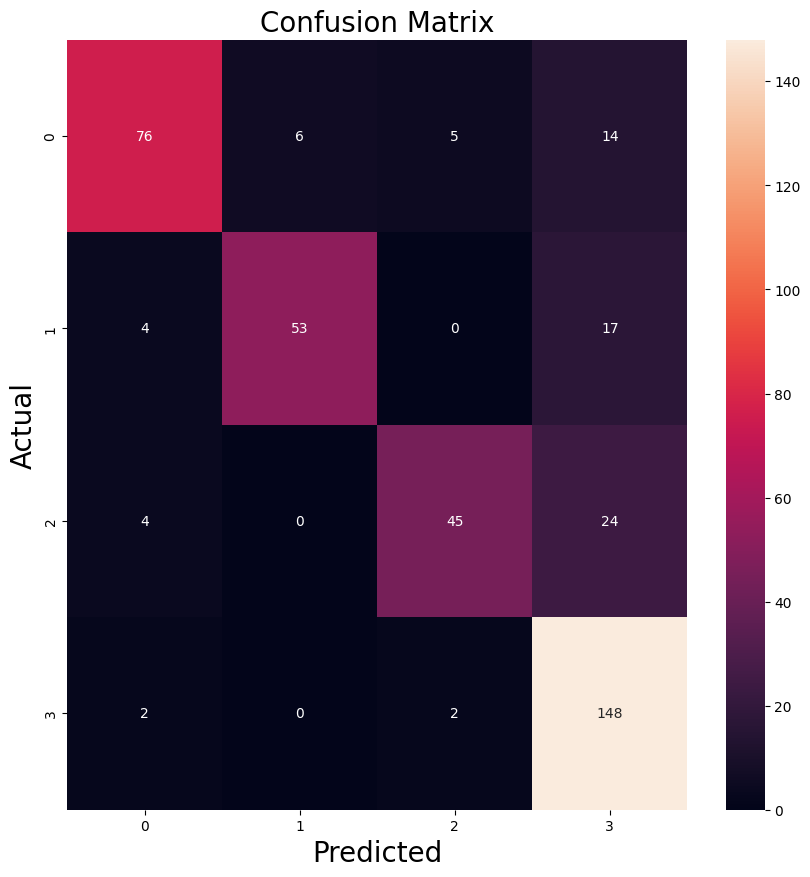

In [10]:
vectorizerResults = tfidfVectorizerAux(subset_data, 1)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    vectorizerResults['X_train'], 
    vectorizerResults['y_train'], 
    vectorizerResults['X_test'], 
    vectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Bigram

0.75 0.8249215802926141 0.75 0.7451354421932472


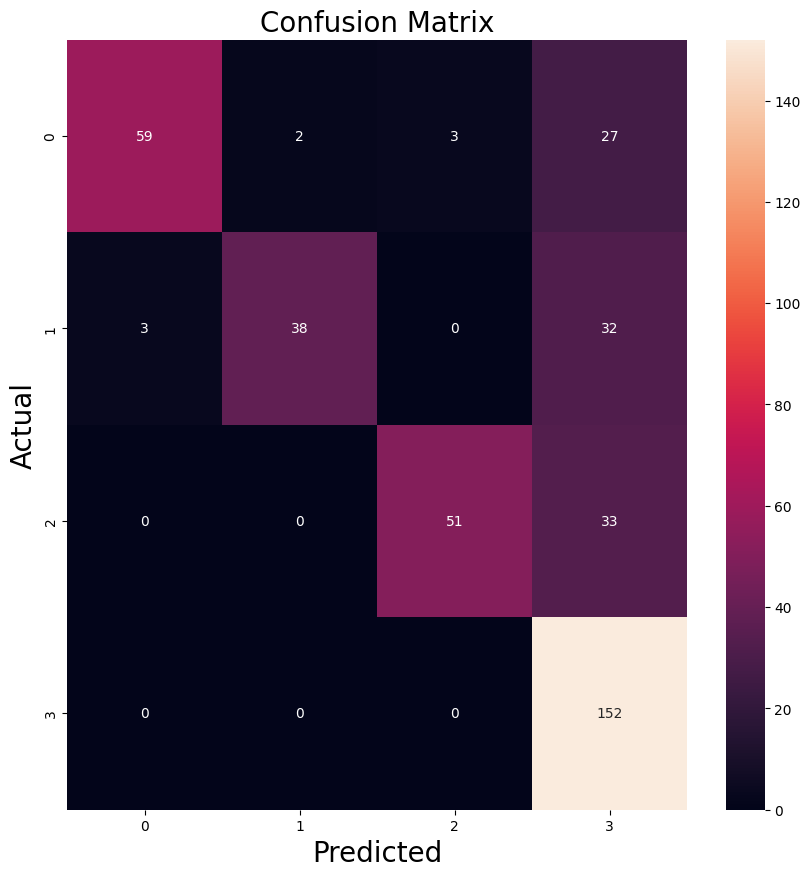

In [11]:
vectorizerResults = tfidfVectorizerAux(subset_data, 2)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    vectorizerResults['X_train'], 
    vectorizerResults['y_train'], 
    vectorizerResults['X_test'], 
    vectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])

##### Trigram

0.6775 0.7836756493506494 0.6775 0.669067597362623


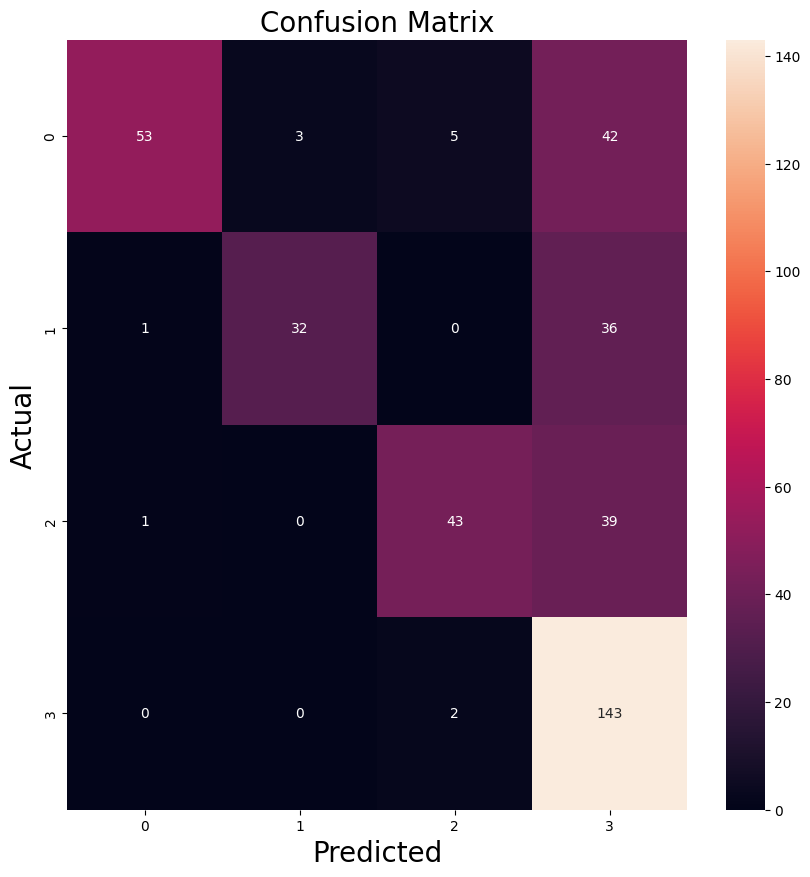

In [12]:
vectorizerResults = tfidfVectorizerAux(subset_data, 3)
results_nb_simple = train_test_model(
    MultinomialNB(), 
    vectorizerResults['X_train'], 
    vectorizerResults['y_train'], 
    vectorizerResults['X_test'], 
    vectorizerResults['y_test'],
    )
print(results_nb_simple['accuracy'], results_nb_simple['precision'], results_nb_simple['recall'], results_nb_simple['f1'])
display_confusion_matrix(results_nb_simple['confusion_matrix'])